In [1]:
%load_ext lab_black
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.random import set_seed

from kaggle_prediction_interval_birthweight.workflow.validation import Validator

np.random.seed(1)
set_seed(1)

In [3]:
def plot_result(obs, lower, upper, lower_new, upper_new):
    fig, ax = plt.subplots(1, 3, figsize=(10, 3))
    ax[0].vlines(x=obs, ymin=lower, ymax=upper, alpha=0.25)
    ax[0].set_xlim(
        np.min(np.concatenate([obs, lower])), np.max(np.concatenate([obs, upper]))
    )
    ax[0].set_ylim(
        np.min(np.concatenate([obs, lower])), np.max(np.concatenate([obs, upper]))
    )
    ax[0].plot([0, 1], [0, 1], transform=ax[0].transAxes, color="orange")
    ax[0].set_xlabel("observations")
    ax[0].set_ylabel("predictions")
    ax[1].hist(lower, bins=100, density=True, color="blue", alpha=0.75, label="train")
    ax[1].hist(
        lower_new, bins=100, density=True, color="orange", alpha=0.75, label="test"
    )
    ax[1].set_xlabel("predicted lower bounds")
    ax[1].legend()
    ax[2].hist(upper, bins=100, density=True, color="blue", alpha=0.75, label="train")
    ax[2].hist(
        upper_new, bins=100, density=True, color="orange", alpha=0.75, label="test"
    )
    ax[2].set_xlabel("predicted upper bounds")
    ax[2].legend()
    plt.show()

In [4]:
data = pd.read_csv("../data/train.csv")
data_test = pd.read_csv("../data/test.csv")

Validation on fold 1 of 2 begins.
Validation on fold 2 of 2 begins.
NOIS is 1859.3 and coverage is 91.3%.


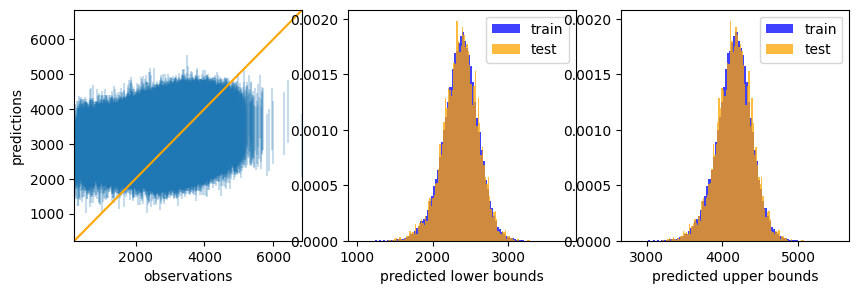

In [5]:
rr_validator = Validator("RidgeRegressor")
rr_validator.fit(data)
rr_validator.print_performance_summary()

lower, upper = rr_validator.predict_intervals(data)
lower_new, upper_new = rr_validator.predict_intervals(data_test)

plot_result(data["DBWT"], lower, upper, lower_new, upper_new)

Validation on fold 1 of 2 begins.
Validation on fold 2 of 2 begins.
NOIS is 1614.0 and coverage is 88.7%.


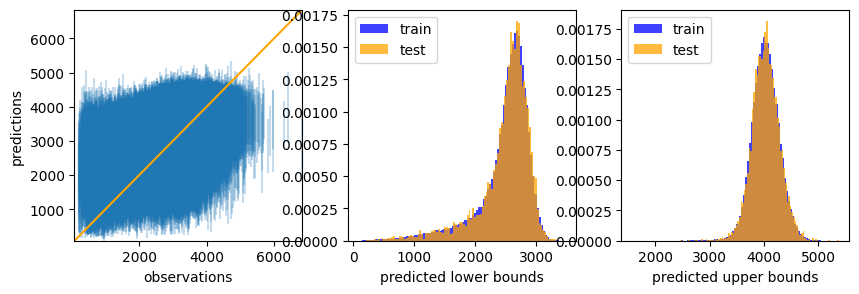

In [6]:
nn_validator = Validator("MissingnessNeuralNet", bayesian=False)
nn_validator.fit(data)
nn_validator.print_performance_summary()

lower, upper = nn_validator.predict_intervals(data)
lower_new, upper_new = nn_validator.predict_intervals(data_test)

plot_result(data["DBWT"], lower, upper, lower_new, upper_new)

Validation on fold 1 of 2 begins.
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Validation on fold 2 of 2 begins.
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
NOIS is 1626.2 and coverage is 88.9%.


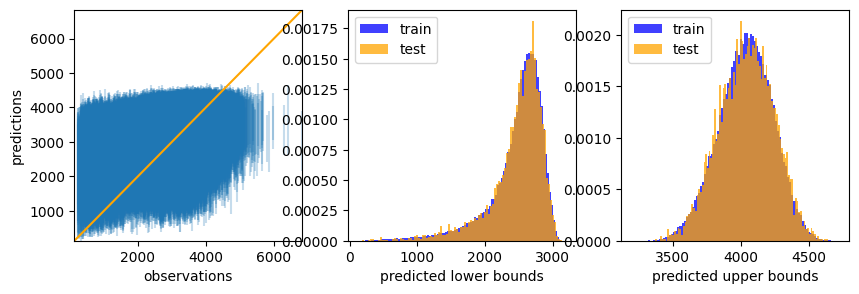

In [7]:
hbr_validator = Validator("HistBoostRegressor")
hbr_validator.fit(data)
hbr_validator.print_performance_summary()

lower, upper = hbr_validator.predict_intervals(data)
lower_new, upper_new = hbr_validator.predict_intervals(data_test)

plot_result(data["DBWT"], lower, upper, lower_new, upper_new)

In [ ]:
hbens_validator = Validator("HistBoostEnsembler")
hbens_validator.fit(data)
hbens_validator.print_performance_summary()

lower, upper = hbens_validator.predict_intervals(data)
lower_new, upper_new = hbens_validator.predict_intervals(data_test)

plot_result(data["DBWT"], lower, upper, lower_new, upper_new)

Validation on fold 1 of 2 begins.
Ensembler fold 1 of 3 begins.
Training the ridge regression model.
Training the histogram boosting model.
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Training the neural network model.
Ensembler fold 2 of 3 begins.
Training the ridge regression model.
Training the histogram boosting model.
Fitting 5 folds for each of 9 candidates, totalling 45 fits


In [ ]:
nnens_validator = Validator("NeuralNetEnsembler")
nnens_validator.fit(data)
nnens_validator.print_performance_summary()

lower, upper = nnens_validator.predict_intervals(data)
lower_new, upper_new = nnens_validator.predict_intervals(data_test)

plot_result(data["DBWT"], lower, upper, lower_new, upper_new)

In [ ]:
rr_lower, rr_upper = rr_validator.predict_intervals(data_test)
data_test[["id"]].assign(pi_lower=rr_lower, pi_upper=rr_upper).to_csv(
    "../data/submission_rr.csv",
    index=False,
)

hbr_lower, hbr_upper = hbr_validator.predict_intervals(data_test)
data_test[["id"]].assign(pi_lower=hbr_lower, pi_upper=hbr_upper).to_csv(
    "../data/submission_hbr.csv",
    index=False,
)

nn_lower, nn_upper = nn_validator.predict_intervals(data_test)
data_test[["id"]].assign(pi_lower=nn_lower, pi_upper=nn_upper).to_csv(
    "../data/submission_nn.csv",
    index=False,
)

hbens_lower, hbens_upper = hbens_validator.predict_intervals(data_test)
data_test[["id"]].assign(pi_lower=hbens_lower, pi_upper=hbens_upper).to_csv(
    "../data/submission_hbens.csv",
    index=False,
)

nnens_lower, nnens_upper = nnens_validator.predict_intervals(data_test)
data_test[["id"]].assign(pi_lower=nnens_lower, pi_upper=nnens_upper).to_csv(
    "../data/submission_nnens.csv",
    index=False,
)

In [ ]:
# one final NN ensembler

from kaggle_prediction_interval_birthweight.data.data_processing import SOFTPLUS_SCALE
from kaggle_prediction_interval_birthweight.model.neural_network import MissingnessNeuralNet
from kaggle_prediction_interval_birthweight.model.sampling_utils import np_softplus_inv


x_final_test = np.hstack([
    rr_lower, rr_upper, 
    hbr_lower, hbr_upper,
    nn_lower, nn_upper,
    hbens_lower, hbens_upper,
    nnens_lower, nnens_upper,
]) / SOFTPLUS_SCALE

rr_l, rr_u = rr_validator.predict_intervals(data)
hbr_l, hbr_u = hbr_validator.predict_intervals(data)
nn_l, nn_u = nn_validator.predict_intervals(data)
hbens_l, hbens_u = hbens_validator.predict_intervals(data)
nnens_l, nnens_u = nnens_validator.predict_intervals(data)

x_final_train = np.hstack([
    rr_l, rr_u, 
    hbr_l, hbr_u,
    nn_l, nn_u,
    hbens_l, hbens_u,
    nnens_l, nnens_u,
]) / SOFTPLUS_SCALE

y_final_train = np_softplus_inv(data["DBWT"].values / SOFTPLUS_SCALE)

final_nn = MissingnessNeuralNet(bayesian=True, fit_tail=False)
final_nn.fit(x_final_train, y_final_train)

In [ ]:
final_lower, final_upper = final_nn.predict_intervals(
    x_final_test, n_samples=10000, alpha=0.9
)
data_test[["id"]].assign(pi_lower=final_lower, pi_upper=final_upper).to_csv(
    "../data/submission_thirdnn.csv",
    index=False,
)